In [1]:
import os
import json

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams["animation.embed_limit"] = 256
matplotlib.rcParams["font.size"] = 22

import IPython

import daisy
import daisy.daisy_world_rl
from daisy.daisy_world_rl import RLDaisyWorld
from daisy.agents.greedy import Greedy


from daisy.daisy_world_simple import SimpleDaisyWorld

#from daisy.agents.greedy import Greedy

# functions for animating daisyworld env
from daisy.notebook_helpers import tensor_to_image,\
        plot_grid,\
        update_fig,\
        update_fig_agent,\
        seed_all
        
my_seed = 42 

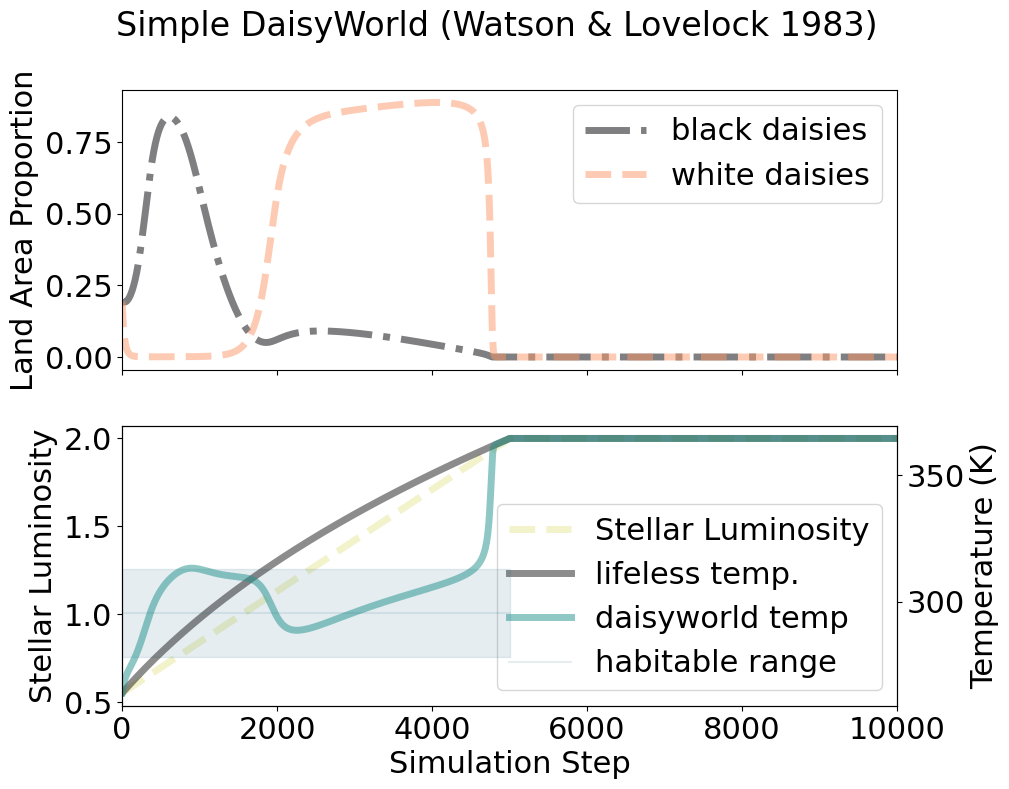

In [2]:
# DaisyWorld (Based on Watson and Lovelock 1983)

daisy_world = SimpleDaisyWorld()

daisy_world.min_L = 0.55
daisy_world.initial_L = daisy_world.min_L
daisy_world.max_L = 2.0
daisy_world.steps_per_period = 10000
daisy_world.reset()
daisy_world.run_sim()
fig, ax = daisy_world.plot_curve(show_habitable=True)

fig.suptitle("Simple DaisyWorld (Watson & Lovelock 1983)", fontsize=24)
plt.show()

In [3]:
def run_q2_sims(q2s, env):
    
    all_lifeless_temps = []
    all_temps = []
    all_dark_daisies = []
    all_light_daisies = []
    all_luminosities = []
    
    for ii, q2 in enumerate(q2s):
    
        if q2 == 0:
            env.q2 = 0
        else:
            env.q2 = env.q / q2
            
        env.reset()
        
        lifeless_temp = []    
        my_temps = []
        my_dark_daisies = []
        my_light_daisies = []
        my_luminosities = []
        
        for step in range(env.ramp_period):
            env.step()
            
            my_temps.append(env.temp.mean())
            my_light_daisies.append(env.grid[:,1,:,:].mean())
            my_dark_daisies.append(env.grid[:,2,:,:].mean())
            my_luminosities.append(env.L)
            
            lifeless_temp.append(env.dead_temp.mean())
                
        all_temps.append(my_temps)
        all_light_daisies.append(my_light_daisies)
        all_dark_daisies.append(my_dark_daisies)
        all_lifeless_temps.append(lifeless_temp)
        all_luminosities.append(my_luminosities)

    return all_lifeless_temps, all_temps,\
            all_light_daisies, all_dark_daisies,\
            all_luminosities
        
def plot_daisyworld_trajectories(q2_values, lifeless_temp, temps,\
        dark_daisies, light_daisies, luminosities, temp_optimal=295.5):
    
    my_cmap = plt.get_cmap("magma")
    fig, ax = plt.subplots(2, 1, figsize=(10,10), facecolor="white")
    ax2 = ax[1].twinx()
    
    
    lines = []
    
    # dead temp  
    dead_temp = lifeless_temp[0]
    # habitable range
    t_range = np.sqrt(1 / 0.003265)
    x = [elem for elem in range(len(dead_temp))]
    lower = [temp_optimal - t_range, temp_optimal - t_range]
    upper = [temp_optimal + t_range, temp_optimal + t_range]
    
    habitable_x = [x[0], x[-1]]
    lines += ax2.plot(habitable_x, [temp_optimal, temp_optimal], alpha=0.3, label="Habitable Range")
    ax2.fill_between(habitable_x, lower, upper, alpha=0.05)
    
    lines += ax[1].plot(x, luminosities[0], "--", lw=4, color=[0.6,0.6,0.6], alpha=0.33, label="Stellar Luminosity")
    lines += ax2.plot(x, dead_temp, "-.", lw=4, color=[0,0,0], alpha=0.33, label="Lifeless Temp.")
    
    for kk, q2 in enumerate(q2_values):
        my_color = list(my_cmap(kk / (len(q2_values)*2) )) 
        
        if q2 == 0:
            ax[0].plot(x, dark_daisies[kk], ":",lw=6, color=my_color,\
                       alpha=0.25, label=f"Dark Daisies $q_2$ = {q2}")
            ax[0].plot(x, light_daisies[kk], "-",lw=6, color=my_color,\
                       alpha=0.25, label=f"Light Daisies $q_2$ = {q2}")

            lines += ax2.plot(x, temps[kk], lw=6, color=my_color,\
                       alpha=0.5, label=f"$q_2$ = {q2}")
        else:
            ax[0].plot(x, dark_daisies[kk], ":",lw=6, color=my_color,\
                       alpha=0.25, label=f"Dark Daisies $q_2$ =q/{q2}")
            ax[0].plot(x, light_daisies[kk], "-",lw=6, color=my_color,\
                       alpha=0.25, label=f"Light Daisies $q_2$ =q/{q2}")

            lines += ax2.plot(x, temps[kk], lw=6, alpha=0.5, label=f"$q_2$ = $q$/{q2}")
    
    ax[0].legend
    ax[0].set_xticklabels("")
    ax2.set_ylabel("Temperature (K)")
    ax[0].set_ylabel("Daisy Coverage")
    ax[1].set_ylabel("Stellar Luminosity")
    
    labels = [line.get_label() for line in lines]
    
    ax[1].axis([0, max(x), 0.65, 1.5])
    
    ax2.axis([0, max(x), 273, 340])
    ax[0].legend(loc=[1.15,0.15], facecolor="white")
    ax[1].legend(lines, labels, loc=[1.15,0.15])
    ax[1].set_xlabel("Simulation Step")
    
    fig.suptitle("2D DaisyWorld with Microclimates")
    return fig, ax

In [221]:
env = RLDaisyWorld()
env.min_L = 0.725
q2s = [0, 64, 8.]

lifeless, temps, light, dark, luminosities = run_q2_sims(q2s, env)

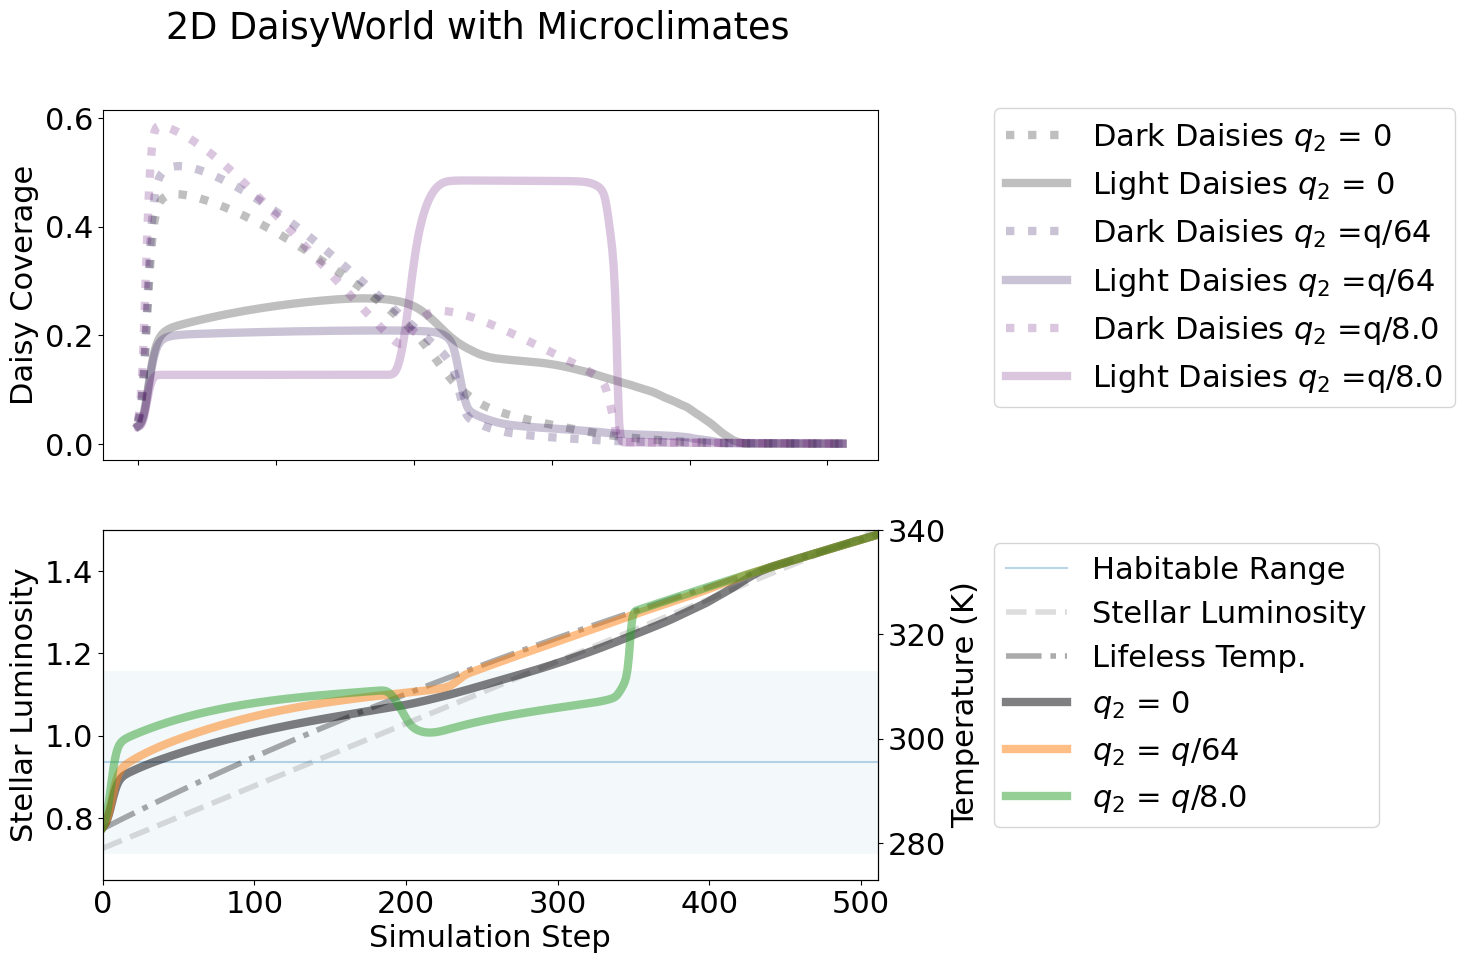

In [222]:
fig, ax = plot_daisyworld_trajectories(q2s, lifeless, temps,\
        dark, light, luminosities)

In [4]:
from daisy.agents.mlp import MLP
from daisy.agents.greedy import Greedy

In [5]:
directory_filepath = "../results/cmaes_exp_002"

dir_list = os.listdir(directory_filepath)

best_fitness = - float("Inf")

for file in dir_list:
    if file.endswith("progress.json"):
    
        with open(os.path.join(directory_filepath, file), "r") as f:
            progress = json.load(f)
            
        
        if np.max(progress["max_fitness"]) > best_fitness:
            best_fitness = np.max(progress["max_fitness"])
            print(f"new best fitness in {file}")
            

new best fitness in cmaes_exp_002_seed13_progress.json
new best fitness in cmaes_exp_002_seed11_progress.json


In [6]:
best_agent = "cmaes_exp_002_seed11_best_agent_gen127.json"

with open(os.path.join(directory_filepath, best_agent), "r") as f:
    
    my_agent = json.load(f)

In [7]:
in_dim = my_agent["in_dim"]
out_dim = my_agent["out_dim"]
h_dim = my_agent["h_dim"]

params = np.array(my_agent["parameters"])

kwargs = my_agent
agent = MLP(**kwargs)

agent.set_parameters(params)

In [22]:
env = RLDaisyWorld()
env.batch_size = 20
env.agent_gamma = 0.0
env.dt = 1.0

seed_all(my_seed)

steps = []

for ii in range(1):
    
    all_done = False
    obs = env.reset()
    done_at = np.zeros((*obs.shape[:1]), dtype=int)
    while not all_done:
        
        obs, reward, done, info = env.step()
        
        
        grid_done = env.grid[:,1:3,:,:].max(axis=(1,2,3), keepdims = False) <= 0.005
        done_at += (1 - 1 * grid_done)
        
        if grid_done.mean() == 1.0:
            all_done = True
            
no_agent_done_at = 1.0 * done_at

In [23]:
no_agent_done_at.mean(), no_agent_done_at.min(), no_agent_done_at.shape

(489.0, 489.0, (20,))

In [18]:


for nn in np.arange(1,301,30):
    env = RLDaisyWorld()
    env.batch_size = 10
    env.n_agents = nn

    seed_all(my_seed)

    steps = []
    for ii in range(1):

        all_done = False
        obs = env.reset()
        done_at = np.zeros((*obs.shape[:1]), dtype=int)

        
        while not all_done:

            action = agent(obs)

            obs, reward, done, info = env.step(action)


            grid_done = env.grid[:,1:3,:,:].max(axis=(1,2,3), keepdims = False) <= 0.005
            done_at += (1 - 1 * grid_done)

            if grid_done.mean() == 1.0:
                all_done = True
        

    agent_done_at = 1.0 * done_at
    
    print(action.min(), action.max(), action.mean(),\
          env.n_agents, agent_done_at.mean(), agent_done_at.min(), agent_done_at)

7 7 7.0 1 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
7 7 7.0 31 499.4 485.0 [503. 485. 503. 503. 503. 503. 503. 485. 503. 503.]
7 7 7.0 61 489.9 385.0 [503. 490. 385. 503. 503. 503. 503. 503. 503. 503.]
7 7 7.0 91 475.2 384.0 [503. 450. 450. 503. 384. 503. 503. 503. 450. 503.]
7 7 7.0 121 420.2 385.0 [397. 400. 385. 450. 397. 385. 503. 385. 397. 503.]
7 7 7.0 151 362.0 16.0 [385. 385.  16. 432. 385. 450. 385. 385. 400. 397.]
7 7 7.0 181 318.2 11.0 [385. 385. 385. 485.  11. 385. 385.  15. 384. 362.]
7 7 7.0 211 213.8 8.0 [400. 385. 503.  17. 396.  10.  12. 397.   8.  10.]
7 7 7.0 241 265.8 9.0 [450.  10. 385. 399.   9.  15. 503.  17. 385. 485.]
7 7 7.0 271 127.4 8.0 [397.   8. 385.  30.  10. 395.   9.  10.  11.  19.]


In [ ]:
agent_done_at.mean(), agent_done_at.min(), #agent_done_at

In [19]:
from importlib import reload
import daisy.agents.greedy
reload(daisy.agents.greedy)

greedy_agent = daisy.agents.greedy.Greedy()

greedy_agent.epsilon = 1.0

for nn in np.arange(1,301,30):
    
    env = RLDaisyWorld()
    env.dt = 1.0
    env.batch_size = 10
    env.n_agents = nn

    seed_all(my_seed)

    steps = []
    for ii in range(1):

        all_done = False
        obs = env.reset()
        done_at = np.zeros((*obs.shape[:1]), dtype=int)

        while not all_done:

            action = greedy_agent(obs)

            obs, reward, done, info = env.step(action)


            grid_done = env.grid[:,1:3,:,:].max(axis=(1,2,3), keepdims = False) <= 0.005
            done_at += (1 - 1 * grid_done)

            if grid_done.mean() == 1.0:
                all_done = True


    greedy_done_at = 1.0 * done_at

    print(env.n_agents, greedy_done_at.mean(), greedy_done_at.min(), greedy_done_at)

1 470.9 467.0 [470. 467. 467. 470. 475. 475. 473. 472. 470. 470.]
31 416.1 402.0 [423. 424. 425. 411. 402. 417. 410. 415. 424. 410.]
61 408.9 387.0 [402. 405. 404. 427. 430. 401. 419. 407. 407. 387.]
91 413.0 399.0 [418. 405. 424. 399. 424. 417. 405. 404. 426. 408.]
121 422.6 401.0 [401. 422. 432. 426. 430. 434. 410. 427. 405. 439.]
151 425.5 401.0 [428. 417. 431. 440. 451. 401. 416. 432. 416. 423.]
181 432.8 419.0 [431. 456. 437. 438. 442. 419. 419. 428. 437. 421.]
211 428.0 407.0 [427. 410. 429. 428. 443. 444. 424. 436. 432. 407.]
241 411.6 380.0 [421. 424. 422. 394. 410. 415. 430. 411. 380. 409.]
271 401.5 353.0 [408. 412. 415. 420. 353. 407. 425. 377. 397. 401.]


In [24]:
from importlib import reload
import daisy.agents.greedy
reload(daisy.agents.greedy)

greedy_agent = daisy.agents.greedy.Greedy()
#greedy_agent.epsilon = 1.0

for nn in np.arange(1,301,30):
    
    env = RLDaisyWorld()
    env.batch_size = 10
    env.n_agents = nn

    seed_all(my_seed)

    steps = []
    for ii in range(1):

        all_done = False
        obs = env.reset()
        done_at = np.zeros((*obs.shape[:1]), dtype=int)

        while not all_done:

            action = greedy_agent(obs)

            obs, reward, done, info = env.step(action)


            grid_done = env.grid[:,1:3,:,:].max(axis=(1,2,3), keepdims = False) <= 0.005
            done_at += (1 - 1 * grid_done)

            if grid_done.mean() == 1.0:
                all_done = True


    greedy_done_at = 1.0 * done_at

    print(env.n_agents, greedy_done_at.mean(), greedy_done_at.min(), greedy_done_at)

1 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
31 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
61 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
91 497.6 485.0 [503. 503. 485. 485. 503. 485. 503. 503. 503. 503.]
121 397.5 16.0 [503.  25. 485. 485. 485. 485. 485. 503.  16. 503.]
151 338.1 11.0 [485. 485. 485. 485.  13.  11. 430. 485.  17. 485.]
181 248.6 7.0 [ 18.  12. 485. 485.  13. 485.  11. 485.   7. 485.]
211 197.7 8.0 [ 13. 485.   8.  10.  13. 458. 485.  10.  10. 485.]
241 197.9 7.0 [ 16. 485.   8.   7. 485.   7. 471.   8.   7. 485.]
271 56.4 6.0 [ 11. 485.   9.  10.   7.   7.  12.   9.   6.   8.]


In [25]:
from importlib import reload
import daisy.agents.greedy
reload(daisy.agents.greedy)

greedy_agent = daisy.agents.greedy.Greedy()
greedy_agent.greedy = False

for nn in np.arange(1,301,30):
    
    env = RLDaisyWorld()
    env.batch_size = 10
    env.n_agents = nn

    seed_all(my_seed)

    steps = []
    for ii in range(1):

        all_done = False
        obs = env.reset()
        done_at = np.zeros((*obs.shape[:1]), dtype=int)

        while not all_done:

            action = greedy_agent(obs)

            obs, reward, done, info = env.step(action)


            grid_done = env.grid[:,1:3,:,:].max(axis=(1,2,3), keepdims = False) <= 0.005
            done_at += (1 - 1 * grid_done)

            if grid_done.mean() == 1.0:
                all_done = True


    greedy_done_at = 1.0 * done_at

    print(env.n_agents, greedy_done_at.mean(), greedy_done_at.min(), greedy_done_at)

1 499.7 485.0 [485. 503. 503. 503. 489. 503. 502. 503. 503. 503.]
31 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
61 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
91 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
121 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
151 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
181 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
211 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
241 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]
271 503.0 503.0 [503. 503. 503. 503. 503. 503. 503. 503. 503. 503.]


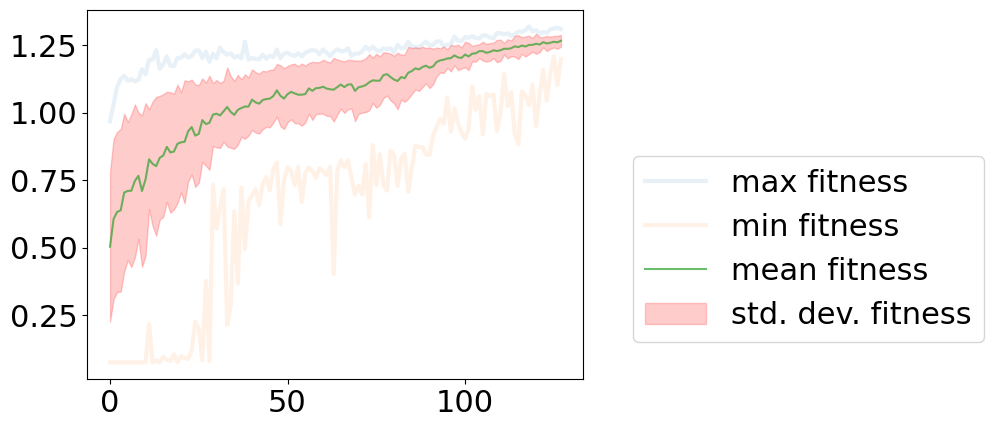

In [260]:
plt.plot(progress["max_fitness"], alpha=0.1, lw=3, label="max fitness")
plt.plot(progress["min_fitness"], alpha=0.1, lw=3, label="min fitness")

plt.plot(progress["mean_fitness"], alpha=0.7, label="mean fitness")

upper = [el1 + np.sqrt(el2) for el1, el2 in zip(progress["mean_fitness"], progress["variance_fitness"])]
lower = [el1 - np.sqrt(el2) for el1, el2 in zip(progress["mean_fitness"], progress["variance_fitness"])]

x = [ii for ii in range(len(upper))]
plt.fill_between(x, lower, upper, label="std. dev. fitness", color="r", alpha=.20)
plt.legend(loc=[1.1,0.1])

In [252]:
help(plt.fill_between)

Help on function fill_between in module matplotlib.pyplot:

fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)
    Fill the area between two horizontal curves.
    
    The curves are defined by the points (*x*, *y1*) and (*x*,
    *y2*).  This creates one or multiple polygons describing the filled
    area.
    
    You may exclude some horizontal sections from filling using *where*.
    
    By default, the edges connect the given points directly.  Use *step*
    if the filling should be a step function, i.e. constant in between
    *x*.
    
    Parameters
    ----------
    x : array (length N)
        The x coordinates of the nodes defining the curves.
    
    y1 : array (length N) or scalar
        The y coordinates of the nodes defining the first curve.
    
    y2 : array (length N) or scalar, default: 0
        The y coordinates of the nodes defining the second curve.
    
    where : array of bool (length N), optional
        Define *